# Predicting Diabetes with Machine Learning Models

Here we use machine learning models for predicting diabetes in the [PIMA dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database) originally from the National Institute of Diabetes and Digestive and Kidney Diseases. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Method

We develop our analysis in three steps.

1. Import and cleaning the data
2. Exploratory Data Analysis
3. Machine Learning Training and Predictions

We check for null values in the data and find that a reasonable amount of Insulin levels and Skin Thickness values need to be replaced, a procedure called __imputation__. A good practice is to replace by the mean value of these quantities. However, this makes the distributions too sharp. Therefore, we produce _normally distributed_ imputation values. Then we move on for some extra exploratory data analysis, on the number of pregnancies per age, the insulin distribution, and the proportion of diabetic patients. This is important to check imbalances in the data. Finally, we train a __Logistic Regression__ estimator to predict diabetes in the dataset. We reach a Sensitivity of 57.8%, a Specificity of 83%, and an Area Under the Curve (AUC) score of 0.82.

## 1. Importing and Cleaning the Data

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [150]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Although there are no NaN values, there are zero values in skin thickness and insulin. We will replace these by the average values of the non-zero observations via an imputer in a ML pipeline. But first let us replace zeros by NaNs, as those are easier to handle with pandas.

In [151]:
for col in ['Insulin', 'SkinThickness']:
    df[col].replace(0, np.nan, inplace=True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35.0,NaN,33.6,0.627,50,1
1,1,85,66,29.0,NaN,26.6,0.351,31,0
2,8,183,64,NaN,NaN,23.3,0.672,32,1
3,1,89,66,23.0,94.0,28.1,0.167,21,0
4,0,137,40,35.0,168.0,43.1,2.288,33,1


Could we drop all NaNs? No, because we miss too many observations!

In [152]:
df_drop = df.dropna()
print("{} missed observations out of {}".format(df.shape[0] - df_drop.shape[0], df.shape[0]))

374 missed observations out of 768


We can replace NaNs by the mean value of each column:

In [153]:
mean_insulin = np.round(df_drop.Insulin.mean(),2)
mean_skin = np.round(df_drop.SkinThickness.mean(),2)
print(mean_insulin, mean_skin)

df_impute = df.replace({'Insulin': {np.nan : mean_insulin}, 'SkinThickness' : {np.nan : mean_skin}})

155.55 29.11


If we compare the new distributions, we see huge spikes in the mean value. 

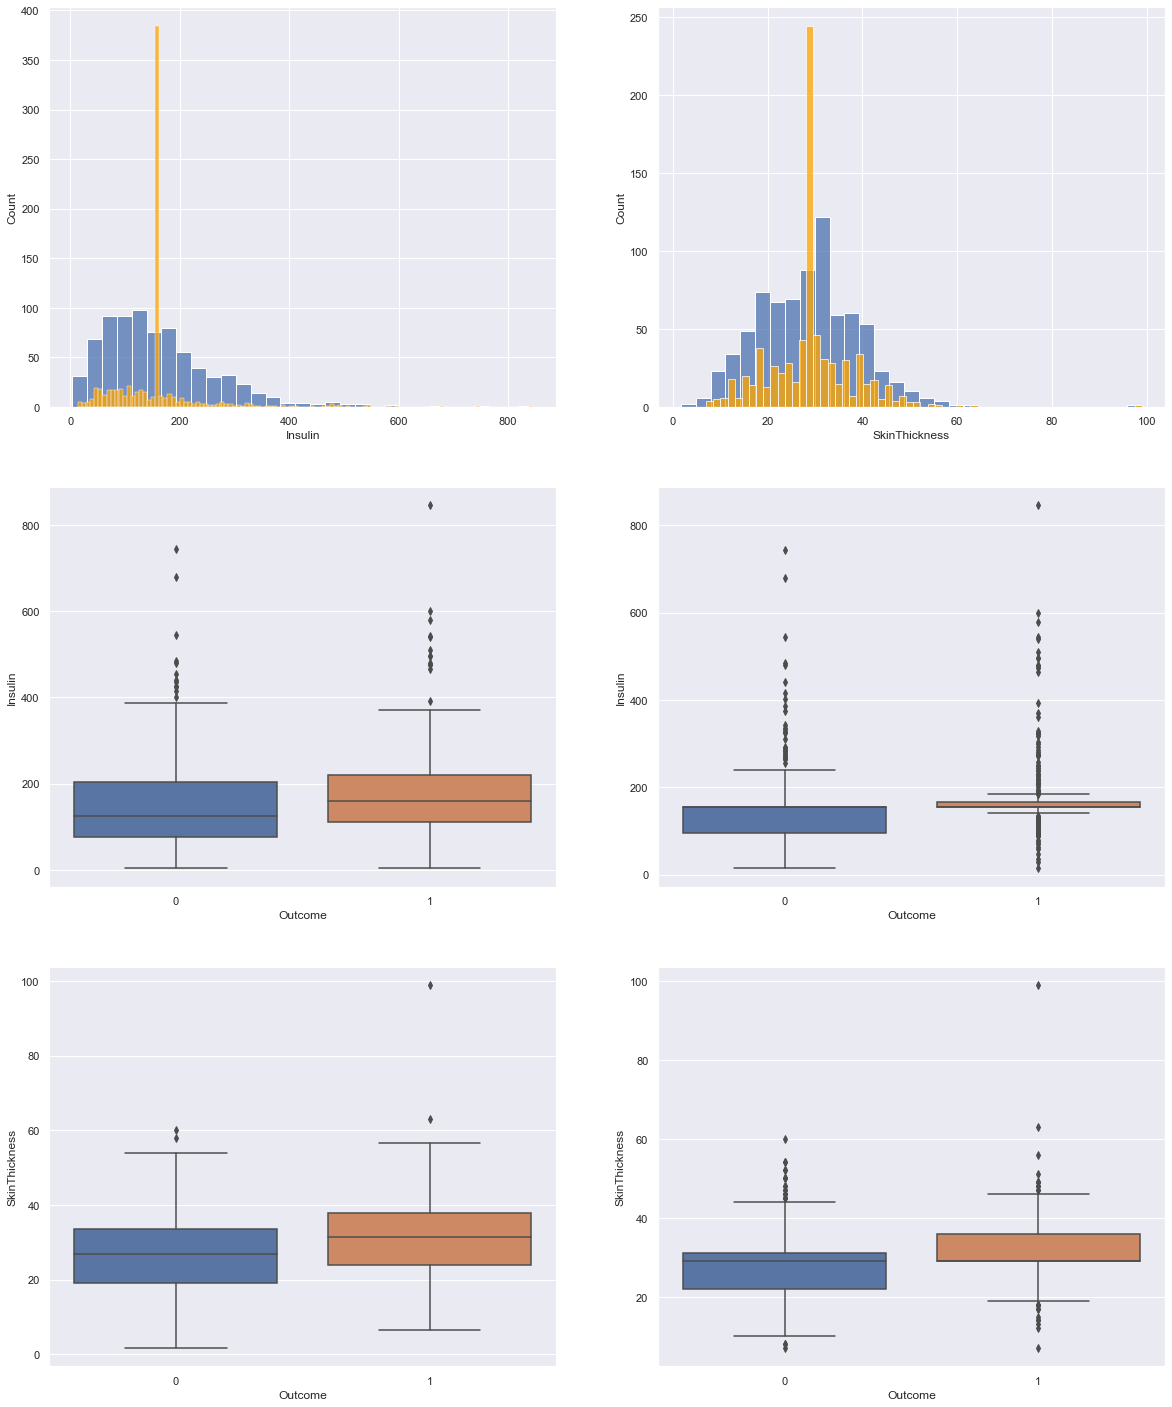

In [176]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(20,25))

sns.histplot(x=df.Insulin, ax=ax[0,0]);
sns.histplot(x=df_impute.Insulin, color='orange',ax=ax[0,0]);
sns.histplot(x=df.SkinThickness, ax=ax[0,1]);
sns.histplot(x=df_impute.SkinThickness, color='orange', ax=ax[0,1]);

sns.boxplot(x=df.Outcome, y=df.Insulin, ax=ax[1,0]);
sns.boxplot(x=df_impute.Outcome, y=df_impute.Insulin, ax=ax[1,1]);
sns.boxplot(x=df.Outcome, y=df.SkinThickness, ax=ax[2,0]);
sns.boxplot(x=df_impute.Outcome, y=df_impute.SkinThickness, ax=ax[2,1]);

This suggests that we are replacing to many values and skewing our distribution. The bottom boxplots show that the variance becomes much smaller for the imputed distributions, specially for the Insulin levels. Therefore, we should not replace all the empty values by the mean, but also spread them with the original variance.

In [155]:
std_insulin = np.round(df_drop.Insulin.std(),2)
std_skin = np.round(df_drop.SkinThickness.std(),2)

normal_insulin = np.random.normal(mean_insulin, std_insulin, 10000)
normal_skin = np.random.normal(mean_skin, std_skin, 10000)

# Choose only positive values among the distribution
normal_insulin = np.random.choice(normal_insulin[normal_insulin > 0],len(df[df.Insulin.isna()]))
normal_skin = np.random.choice(normal_skin[normal_skin > 0],len(df[df.SkinThickness.isna()]))

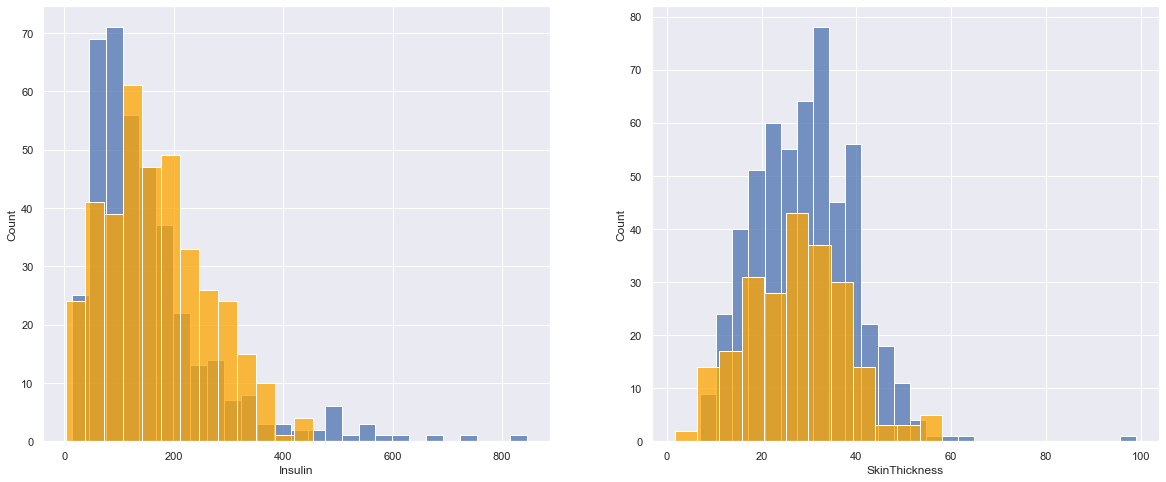

In [156]:
fig, ax = plt.subplots(ncols=2,figsize=(20,8))

sns.histplot(x=df.Insulin, ax=ax[0]);
sns.histplot(normal_insulin, color='orange',ax=ax[0]);
sns.histplot(x=df.SkinThickness, ax=ax[1]);
sns.histplot(normal_skin, color='orange', ax=ax[1]);

In [157]:
df_insulin = pd.DataFrame({'Insulin': normal_insulin}, index=df[df.Insulin.isna()].index.values)
df.Insulin.fillna(df_insulin.Insulin, inplace=True)

df_skin = pd.DataFrame({'SkinThickness': normal_skin}, index=df[df.SkinThickness.isna()].index.values)
df.SkinThickness.fillna(df_skin.SkinThickness, inplace=True)

In [158]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35.000000,8.830521,33.6,0.627,50,1
1,1,85,66,29.000000,167.130982,26.6,0.351,31,0
2,8,183,64,12.397622,184.558848,23.3,0.672,32,1
3,1,89,66,23.000000,94.000000,28.1,0.167,21,0
4,0,137,40,35.000000,168.000000,43.1,2.288,33,1


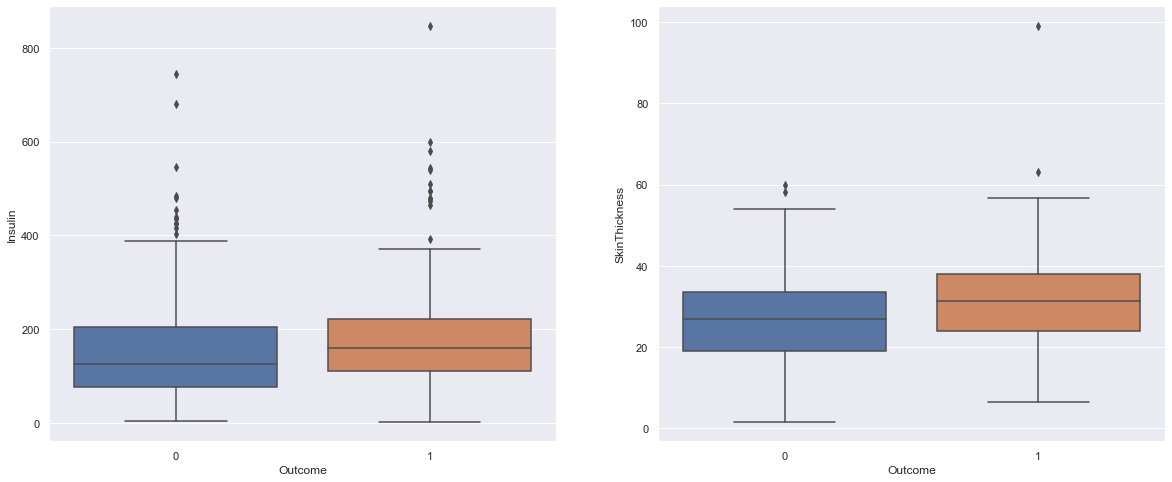

In [180]:
fig, ax = plt.subplots(ncols=2, figsize=(20,8))

sns.boxplot(x=df.Outcome, y=df.Insulin, ax=ax[0]);
sns.boxplot(x=df.Outcome, y=df.SkinThickness, ax=ax[1]);

Those distributions now do not contain empty values and those were replaced by normally distributed values around the mean.

## 2. Exploratory Data Analysis

We can now make some exploratory plots. Let us check the age distribution of the patients.

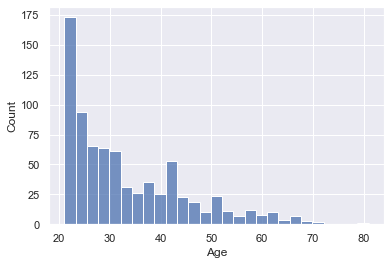

In [181]:
sns.histplot(x='Age', data=df_impute, bins=int(np.sqrt(len(df_impute))));

We see that most patients are young, with ages between 20 and 30 years old. 

Is there any relation between the number of pregnancies and the age?

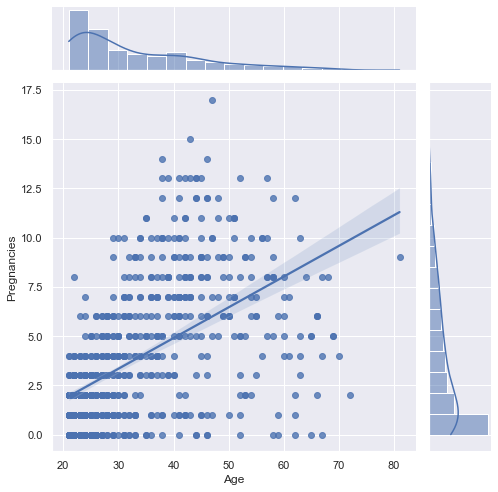

In [80]:
g = sns.jointplot(data=df_impute, x='Age', y='Pregnancies', kind='reg', height=7)

We see a clear tendency of older women having more pregnancies. Moreover, the histograms in the sides confirm that younger women tend to have less than 3 pregnancies.

Now let us check the distribution of Insulin levels between patients that have diabetes or not. Should this be higher for diabetic patients?

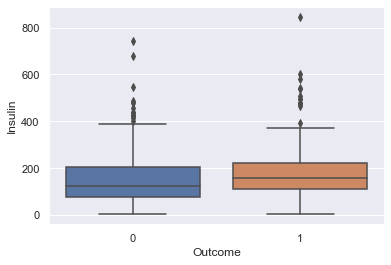

In [206]:
sns.boxplot(x='Outcome', y='Insulin', data=df);

There seems to be slightly higher values of insulin levels for diabetic women. However, this might be a reflection that we replaced a large number of missing data by normally distributed values. 

Finally, let us check if our dataset is imbalaced, with too many patients with our without diabetes.

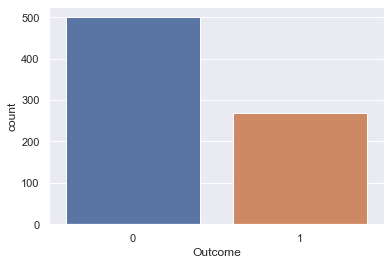

In [207]:
sns.countplot(x='Outcome', data=df_impute);

There is a relative imbalance, but we still have a good proportion of diabetic patients to achieve an accurate machine learning.

## 2. Machine Learning Prediction

Now let us start our ML pipeline using scikit-learn. This will involve 2 steps:  scaling and training the data. We train the data using Logistic Regression, and use GridSearchCV to do hyperparameter estimation and cross-validation, all in one single pipeline.

In [192]:
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define input data with target = diabetes
X = df.drop(['Outcome'], axis=1).values
y = df.Outcome.values

# Define the pipeline steps and call it
steps = [#('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),\
         ('scale', StandardScaler()), ('logreg', LogisticRegression())]
pipeline = Pipeline(steps)

# Specify the hyperparameter space
max_iter = [100, 200, 300]
tol = [0.1, 0.01, 0.001]
c_space = np.logspace(-5, 8, 15)
#parameters = {'logreg__max_iter': max_iter, 'logreg__tol':tol, 'logreg__C': c_space} #, 'logreg__penalty': ['l1', 'l2']
parameters = {'logreg__tol': tol, 'logreg__C': c_space}

# Split Train and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create GridSearchCV object
logreg_grid_cv = GridSearchCV(pipeline, parameters, cv=5)

# Fit to the training set
logreg_grid_cv.fit(X_train, y_train)

# Predict
y_pred = logreg_grid_cv.predict(X_test)

# Compute and print the metrics
r2 = logreg_grid_cv.score(X_test, y_test)
print("Tuned LogisticRegression Parameters: {}".format(logreg_grid_cv.best_params_))
print("Tuned LogisticRegression R squared: {}".format(r2))
print("\n", classification_report(y_test, y_pred))

Tuned LogisticRegression Parameters: {'logreg__C': 0.05179474679231213, 'logreg__tol': 0.1}
Tuned LogisticRegression R squared: 0.7467532467532467

               precision    recall  f1-score   support

           0       0.80      0.83      0.81       206
           1       0.63      0.58      0.60       102

    accuracy                           0.75       308
   macro avg       0.71      0.70      0.71       308
weighted avg       0.74      0.75      0.74       308



In [193]:
logreg_grid_cv.best_score_

0.7717391304347826

The confusion matrix is defined by

|             | predicted: real | predicted: spam |
|-------------|-----------------|-----------------|
| actual real | True Negatives  | False Positives |
| actual spam | False Negatives | True positives  |

In [194]:
cfs = confusion_matrix(y_test, y_pred)
print(cfs)

[[171  35]
 [ 43  59]]


From this we can compute the Sensitivity, or percentage of True Positives (tp), and Specificity, or percentage of True Negatives (tn), of our test

$$ \text{Sensitivity} = \frac{tp}{tp + fn}, \quad \text{Specificity} = \frac{tn}{tn + fp} $$

In [204]:
sens = cfs[1,1]/(cfs[1,1]+cfs[1,0])
spec = cfs[0,0]/(cfs[0,0]+cfs[0,1])
print("The Sensitivity is {}%".format(100*sens), "\nThe Specificity is {}%".format(100*spec))

The Sensitivity is 57.84313725490197% 
The Specificity is 83.00970873786407%


These match the Recall values in the classification report.

Let us compute the ROC curve and the area under the curve, which is a score of how good is our model.

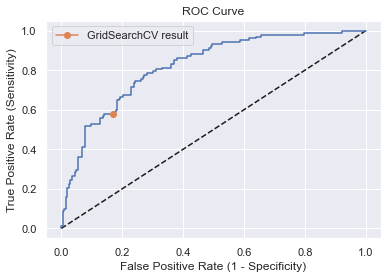

Area under the curve (AUC) = 0.8214829621168855


In [205]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute predicted probabilities
y_pred_prob = logreg_grid_cv.predict_proba(X_test)[:,1]

# Generate ROC curve values: false positive ratio, true positive ratio, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.plot(1-spec, sens, marker='o', label='GridSearchCV result')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("Area under the curve (AUC) =", roc_auc_score(y_test, y_pred_prob))

A perfect model has AUC equal to 1, which would be only true positives, no false positives. Therefore, our result of 0.82 is quite good to predict diabetes.

## Next steps
- Test different models.
- Use an Ensemble technique.
- Try a Boosting technique.